# Dataset Statistics

Saving to: c:\Users\alexh\Desktop\ComputerVision\Hausarbeit\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json
number of images: 1362
number of annotations: 875337
avg number of annotations per image: 642.6850220264317
number of classes: 114


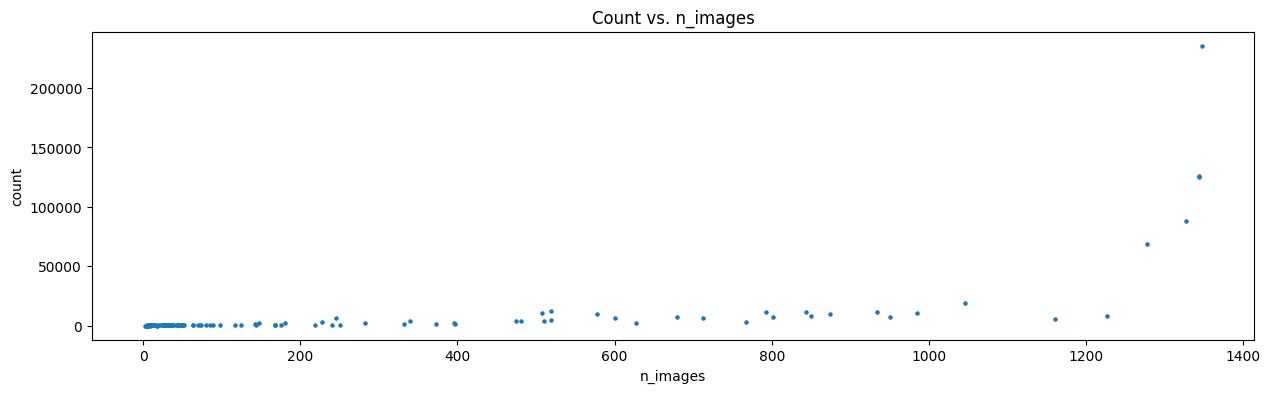

In [1]:
from importlib import reload
import util
import eval

de = util.DataExtractor()
gt_df = de.croppedData()
classes = eval.classReport(gt_df)

In [2]:
classes_sorted = classes.sort_values("%_images", ascending=False)
classes_sorted[40:60].head(20)

,class_id,count,name,n_images,%_images
40,49,891,flag16thUp,176,12.922173
46,55,691,flag16thDown,168,12.334802
72,3,231,segno,168,12.334802
34,73,1765,articStaccatoBelow,148,10.866373
48,80,649,fermataAbove,143,10.499266
35,70,1535,articAccentAbove,142,10.425844
42,15,823,timeSig3,124,9.104258
41,71,829,articAccentBelow,117,8.590308
97,105,132,ornamentTurnInverted,98,7.195301
73,103,230,ornamentTrill,89,6.534508


In [8]:
lowest = classes.iloc[-10:].sort_values("%_images", ascending=False)

lowest

,class_id,count,name,n_images,%_images
105,98,29,dynamicR,17,1.248164
106,129,21,tuplet5,9,0.660793
104,44,35,tremolo3,6,0.440529
108,66,6,accidentalDoubleFlat,5,0.367107
111,130,5,tuplet7,5,0.367107
110,131,5,tuplet8,5,0.367107
112,126,4,tuplet1,4,0.293686
107,42,16,tremolo1,3,0.220264
109,128,6,tuplet4,3,0.220264
113,132,2,tuplet9,2,0.146843
